# Data Inspection

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2

In [2]:
# Don't seem particularly relevant to the data we have
labels = pd.read_csv("../dataset/labels.csv")
labels.head()

,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL


In [3]:
# So I'm going to populate my own dataframe
img_paths = []
img_types = []
train_dir = "../dataset/images/TRAIN/"
cell_types = ["EOSINOPHIL","LYMPHOCYTE","MONOCYTE","NEUTROPHIL"]

In [4]:
for c_type in cell_types:
    path = train_dir + c_type
    for p in os.listdir(path):
        img_paths.append(path+"/"+p)
        img_types.append(c_type)
labels = pd.DataFrame({"cell_type": img_types,"img_path":img_paths})
        

In [ ]:
# All of them
labels.head()

In [ ]:
# Shuffle the labels:
labels = labels.sample(frac=1).reset_index(drop=True)

In [ ]:
# Seems pretty hard to tell them apart
for i, row in enumerate(labels.head().values):
    cell_type, path = row
    plt.figure(i)
    plt.imshow(Image.open(path))
    plt.title(cell_type)
plt.show()


# Preprocessing Experimentation:

## Masking

In [ ]:
test_img = Image.open(labels["img_path"][1])
array_img = np.array(test_img)
# array_img.reshape(array_img.shape[:-1])
plt.figure(0)
plt.imshow(test_img)
plt.title("Original")
channel_images = []
for i in range(3):
    plt.figure(i+1)
    img = array_img[:,:,i]
    channel_images.append(img)
    plt.imshow(Image.fromarray(img).convert("LA"))
    plt.title("Channel " + str(i+1))
plt.show()


In [ ]:
array_img[:,:,i].shape
array_img[:,:,i][0][0]

In [ ]:
# Removing the black outside with white so masking works effectively 
elim_black = lambda x : 255 if x < 40 else x
vfunc = np.vectorize(elim_black)
whitened_images = []
for img in channel_images:
    whitened_images.append(vfunc(img))

In [ ]:
whitened_images[0]

In [ ]:
# Checking
Image.fromarray(whitened_images[1].astype('uint8'))

In [ ]:
# Now mask back out the light stuff:
elim_white = lambda x : 255 if x > 140 else x
vfunc = np.vectorize(elim_white)
center_images = []
for img in channel_images:
    center_images.append(vfunc(img))

In [ ]:
Image.fromarray(center_images[0])

In [ ]:
xS = []
yS = []

img = center_images[0]
for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        if img[x][y] < 200 and img[x][y] > 60:
            xS.append(x)
            yS.append(y)

In [ ]:
cX = np.mean(xS)
cY = np.mean(yS)
center = (int(cX), int(cY))
final_image = array_img[center[0]-48:center[0]+48,center[1]-48:center[1]+48,:]

In [ ]:
Image.fromarray(final_image)
# Bingo

In [ ]:
# Final Image
def convert_image(path):
    starter_img = Image.open(path)
    array_img = np.array(starter_img)
    blue_image = array_img[:,:,1]
    

    elim_black = lambda x : 255 if x < 40 else x
    vfunc = np.vectorize(elim_black)
    whitened_image = vfunc(blue_image).astype("uint8")
    
    thresh=whitened_image.min()*1.4
    xS = []
    yS = []
    while len(xS) < 64:
        elim_white = lambda x : 255 if x > thresh else x
        vfunc2 = np.vectorize(elim_white)
        center_image = vfunc2(whitened_image).astype("uint8")

        for x in range(center_image.shape[0]):
            for y in range(center_image.shape[1]):
                if center_image[x][y] < 200 and center_image[x][y] > 60:
                    xS.append(x)
                    yS.append(y)
        cX = np.mean(xS)
        cY = np.mean(yS)
        if np.isnan(cX) == False:
            center = (int(cX), int(cY))
            padded = np.pad(array_img, ((56, 56), (56, 56), (0,0)), 'constant', constant_values=0)
#             return padded
            final_image = padded[center[0]:center[0]+112,center[1]:center[1]+112,:]
        else:
            xS = []
            yS = []
            thresh+=thresh*0.2
    return final_image

In [ ]:
k=0

In [ ]:
k

In [ ]:
# Testing Generalization:
sample = labels.sample(n=3, random_state=k)
for i, row in enumerate(sample.values):
    cell_type, path = row
    plt.figure(i)
    plt.imshow(Image.fromarray(convert_image(path)))
    plt.title(cell_type)
k+=1

In [ ]:
# Temp test image
t_img = convert_image(labels["img_path"][151])

## Normalizing

In [ ]:
# Effects of a Gaussian Filter:
plt.figure(0)
plt.imshow(t_img)
plt.title("Original")
plt.figure(1)
plt.imshow(cv2.GaussianBlur(t_img,(3,3),0))
plt.title("Original")

In [ ]:
# Normalization strategy:
def normalize_img(im_ar):
#   Gaussian Blur to start with 3x3 kernel
    im_ar = cv2.GaussianBlur(im_ar,(3,3),0)
    xMin = im_ar.min()
    xMax = im_ar.max()
    im_ar = (im_ar-xMin)/(xMax-xMin)
    return im_ar
    

In [ ]:
# Example:
Image.fromarray(normalize_img(t_img))

In [ ]:
# Testing Generalization:
sample = labels.sample(n=3, random_state=k)
for i, row in enumerate(sample.values):
    cell_type, path = row
    plt.figure(i)
    im = normalize_img(convert_image(path).astype("float"))
    print(im.mean())
    print(im.min())
    plt.imshow(Image.fromarray(im.astype("uint8")))
    plt.title(cell_type)
k+=1

# Testing the Preprocessed Data

In [52]:
rendered_images = ["../dataset/processed_images/train/"+f for f in os.listdir("../dataset/processed_images/train/")]

In [53]:
path = rendered_images[1]
with open(path, 'rb') as f:
    t= pickle.load(f)
    print(t.shape)

(112, 112, 3)


In [10]:
import pickle
def parse_pickle(path):
    with open(path, 'rb') as f:
        t= pickle.load(f)
        t = np.dstack(t*100).astype('uint8')
        t_reshaped = np.transpose(t, (0, 2, 1))
        return Image.fromarray(t_reshaped)

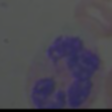

In [37]:
import random
parse_pickle(rendered_images[random.randint(0,len(rendered_images)-1)])